# Analysis summary, figures and results
## Summary

Measuring associations between localized brain lesions and cognitive impairments in stroke patients is a powerful approach for establishing brain-behaviour relationships. However, the distal effects of such lesions on brain connectivity and behaviour are not well understood. In the current study we hypothesized that damage to white matter tracts and highly connected cortical regions would result in widespread connectivity deficits related to multiple, correlated behaviours. We investigated this hypothesis by modelling white matter damage within a stroke patient cohort (N = 80) and related these ‘lesion-connectivity patterns’ to a broad range of behavioural impairments in the domains of visual perception, attention, reasoning, language and IQ, all within a multivariate statistical framework. Using canonical correlation analysis we found that a single principle axis relating behavioural deficits and lesion damage. Consistent with previous work this pattern conformed to a left-right hemispheric bias for language, on the one hand, and attention, on the other. More specifically, the predictive connections associated with language were dominated by highly weighted subcortical connections, whereas the attention-related was dominated by damage the fronto-parietal "control" network. Critically, using this low-dimensional approach single-subject behavioural scores could be predicted in a leave-one-out fashion across multiple behaviours. Our findings highlight the importance of lesion-network approaches in explaining complex clusters of behavioural deficits following stroke, and the potential for predicting recovery and optimizing rehabilitative interventions in the future.



In [17]:
#Import modules
import scipy.io
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib import cm as colmap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
parc = 'Sch214'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')
MNIcoordinates = data['COG']

In [2]:
#Plotting functions
from scipy.stats import gaussian_kde
from numpy.polynomial.polynomial import polyfit
plt.style.use('seaborn-white')
medium_size = 10
large_size = 12
beh_labels = [
    'NART_IQ', 'APM', 'Q1_TotalWords', 'Q6_TotalCorrect', 'CoC_abs_rev'
]
net_labels = [
    'Visual', 'SomatoMotor', 'DorstAttn', 'SalVentAttn', 'Limbic', 'Control',
    'Default', 'SubCortical'
]
plt.rc('font', size=large_size)  # controls default text sizes
plt.rc('axes', titlesize=large_size)  # fontsize of the axes title
plt.rc('axes', labelsize=large_size)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=large_size)  # legend fontsize
plt.rc('figure', titlesize=large_size)  # fontsize of the figure title


def do_threshold(mat, num_edge=100):
    num_edge = np.int(num_edge / 2)
    nRoi = np.shape(mat)[0]
    mat_pos = np.zeros((np.shape(mat)))
    mat_neg = np.zeros((np.shape(mat)))

    # take the upper triangle
    idx = np.triu_indices(nRoi, k=1)
    mat_vec = mat[idx]

    # order it (positive)
    mat_vec = mat[idx]
    cutoff = np.flip(np.argsort(mat_vec))
    mat_vec[cutoff[num_edge::]] = 0
    mat_pos[idx] = mat_vec

    # order it (negative)
    mat_vec = mat[idx]
    cutoff = np.argsort(mat_vec)
    mat_vec[cutoff[num_edge::]] = 0
    mat_neg[idx] = mat_vec

    mat_new = (mat_pos + mat_pos.T) + (mat_neg + mat_neg.T)
    return mat_new


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()


def mode_UV_plot(x, y, r, r_perms):
    ## Permutation plot
    plt.figure(figsize=(2.8, 0.5))
    sns.distplot(r_perms, color='darkgray')
    plt.scatter(np.mean(r),
                2,
                s=30,
                alpha=1,
                linewidth=0,
                color=colmap.viridis(0.75))

    remove_border(left=False, bottom=False)
    plt.xlabel("r value")
    #plt.xlim(0.3, 0.85)
    plt.xticks([0.4, 0.5, 0.6, 0.7])
    plt.yticks([])
    plt.show()

    # Fit with polyfit
    b, m = polyfit(x, y, 1)

    # Calculate the point density for alpha values
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    z = (1 - z * 2) - .2

    colors = np.zeros((len(z), 4))
    for i in range(len(z)):
        colors[i, :] = colmap.viridis(0.5)
        colors[i, 3] = np.float(z[i])

    plt.figure(figsize=(3.2, 2.4))
    plt.scatter(x, y, s=40, linewidth=0, color=colors)
    plt.plot(x, b + m * x, '-', linewidth=1, color='darkgray')

    #params
    plt.xlim(-2.8, 2.8)
    plt.ylim(-2.8, 2.8)
    plt.xlabel("Behaviour weights (arb. unit)")
    plt.ylabel("Connectivity weights (arb. unit)")
    remove_border()
    plt.show()


def mode_BW_plot(x):
    x = behaviour_loading[:, mode]
    y_pos = np.arange(len(x))
    colors = colmap.viridis((x + 1) / 2)

    plt.figure(figsize=(2.4, 2.4))
    plt.barh(y_pos, x, align='center', color=colors, ecolor=colors)
    plt.xlim(-0.9, 0.9)
    plt.yticks([0, 1, 2, 3, 4, 5], beh_labels)
    plt.xlabel("Correlation between behaviour and CCA mode (r)")
    remove_border(left=None)
    plt.show()


def mode_prediction_plot(real_values, predicted_values, r_values,
                         perm_r_values):
    beh_labels = [
        'NART_IQ', 'APM', 'Q1_TotalWords', 'Q6_TotalCorrect', 'CoC_abs_rev'
    ]
    plt.figure(figsize=(12, 1.5))
    for i in range(np.shape(real_values)[1]):
        ## Permutation plot
        plt.subplot(1, np.shape(real_values)[1], i + 1)
        sns.distplot(perm_r_values[:, i], color='darkgray')
        plt.scatter(r_values[i],
                    2,
                    s=30,
                    alpha=1,
                    linewidth=0,
                    color=colmap.viridis(0.75))
        remove_border(left=False, bottom=False)
        plt.title(beh_labels[i])
        plt.xlabel("r value")
        plt.yticks([])
        plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 2.4))
    for behaviour in range(np.shape(real_values)[1]):
        ## scatter plot
        x = predicted_values[:, behaviour]
        y = real_values[:, behaviour]

        # Fit with polyfit
        b, m = polyfit(x, y, 1)

        # Calculate the point density for alpha values
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        z = (1 - z * 2) - .2

        colors = np.zeros((len(z), 4))
        for i in range(len(z)):
            colors[i, :] = colmap.viridis(0.5)
            colors[i, 3] = np.float(z[i])

        plt.subplot(1, np.shape(real_values)[1], behaviour + 1)
        plt.scatter(x, y, s=40, alpha=0.5, linewidth=0, color=colors)
        plt.plot(x, b + m * x, '-', linewidth=1, color='darkgray')

        #params
        lim = np.max([np.max(np.abs(x)), np.max(np.abs(y))])
        #plt.xlim(lim*-1,lim)
        #plt.ylim(lim*-1,lim)
        #plt.title(beh_labels[behaviour])
        plt.xlabel("Predicted behaviour")
        plt.ylabel("Actual behaviour")
        remove_border()
        plt.tight_layout()
    plt.show()


def node_plot(node_data, n, title_label):
    node_data_rank = np.argsort(node_data * -1, axis=0)
    idx = node_data_rank[0:n]

    #normalise for vis
    node_data = node_data[idx]
    node_data_vis = (node_data - min(node_data)) / max(
        (node_data - min(node_data)))

    colors = colmap.viridis(node_data_vis)
    colors_new = colors[:, :, :, 0:3]
    colors_new = np.reshape(colors_new, (n, 3))

    cm = np.zeros(shape=(n, n))
    coords = np.reshape(MNIcoordinates[idx, :], (n, 3))
    plotting.plot_connectome(cm,
                             coords,
                             node_size=node_data_vis * 100,
                             node_color=colors_new,
                             title=title_label,
                             display_mode='lzr',
                             edge_kwargs={'Alpha': 0.75},
                             node_kwargs={'Alpha': .80})
    plt.show()

## Lesions, connectivity lesion-mapping and behaviour
Post-stroke behaviour is generally correlated. We used five different measures of interest:
- NART_IQ: IQ score based on the National Adult Reading Test (NART). We *wouldn't* expect this to change with stroke damage considering it is often used as a "premorbid IQ" measure.
- APM: The first set of the Raven's Advanced Progressive Matrices.
- Q1_TotalWords: Language measure
- Q6_TotalCorrect: Verbal fluency language measure
- CoC_abs_rev: Spatial Neglect cancellation task absolute value.

Previous work has shown that post-stroke behaviour is correlated and has a simple three factor solution <cite data-cite="1496076/F6P2EDLD"></cite> Unfortunately we don't have enough breadth of behavioural variables to show this.

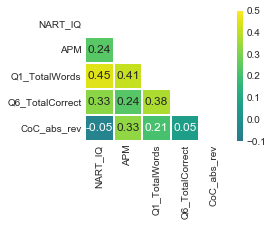

In [3]:
# Behavioural correlation heatmap
beh_tf = data['behav'][0][0][4]
corr = np.corrcoef(beh_tf.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(3.2, 2.4))
sns.heatmap(corr,
            vmin=-0.1,
            vmax=0.5,
            cmap='viridis',
            center=0,
            annot=True,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=beh_labels,
            yticklabels=beh_labels)
plt.show()

### Lesion density plot
Our stroke locations are typical for the literature. Usually, this map would be thresholded for a VLSM analysis (~10% of the sample), meaning that only regions around the insula would be tested.

Colourbar indicates overlap across participants. The strange wispy lines are from changing the MNI space of the images (it doesn't affect the lesion-network mapping).

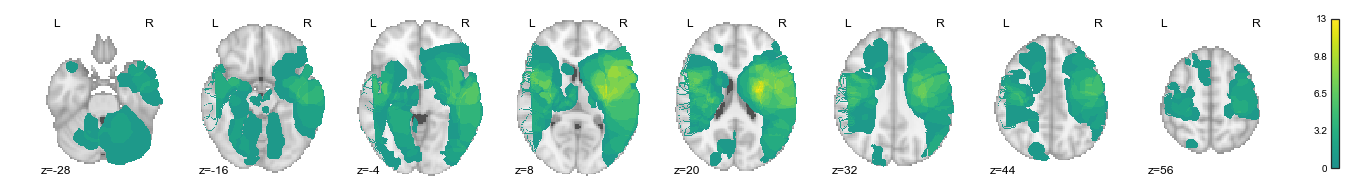

In [4]:
#plot summed lesion map
img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/LesionOverlap.nii'
slices = np.arange(-28, 62, 12)
plotting.plot_stat_map(img,
                       threshold=0,
                       colorbar=True,
                       cmap='viridis',
                       display_mode='z',
                       cut_coords=(slices))
plt.show()

### Lesion-connectivity mapping density plot
These are the estimated lesioned connections based on 20 similarly aged and gender matched controls from the NKI database. Nearly every connection is implicated across participants.

Colourbar indicates overlap across participants

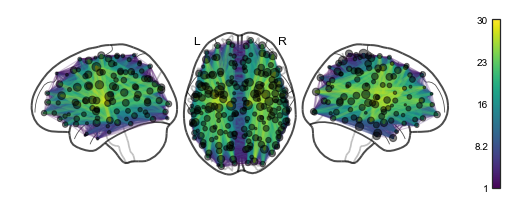

In [5]:
# plot summed lesion-connectivity map
cm = data['Cdiff']
cm[cm > 0] = 1
cm = np.sum(cm, axis=2)
cm = cm + cm.T
cm_degree = np.sum(abs(cm), axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 100
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=1,
                         edge_vmax=30,
                         colorbar=True,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.25},
                         node_kwargs={'Alpha': 0.50})
plotting.show()
plt.show()

## Dimensionality reduction: multiple correspondance analysis (MCA) results
We used MCA to reduce the potential edges used in the CCA (~10,000) to a smaller number of components (tested from 7 - 20). MCA can be thought of as a alternative to PCA for data that is binary. In our case, a PCA is inappropriate because a vector of connections would include many 0's (not damaged connections) and a few weighted connections, resulting in a non-normal distribution. As an added bonus, using binary data lends itself to comparison with the raw lesion maps (which are also binary).

These maps can be interpreted as the patterns of damage and undamaged connectivity that account for the most variance across participants, i.e. "common lesion connectivity damage patterns". The first two, perhaps not surprisingly are left and right hemisphere damage stemming from the insula.

Mean variance explained for components (%) [20.51294935  9.69037583  5.13592384  4.66652438  4.14142755  3.49680669
  3.10184957  2.75664116  2.58948542  2.4559511 ]


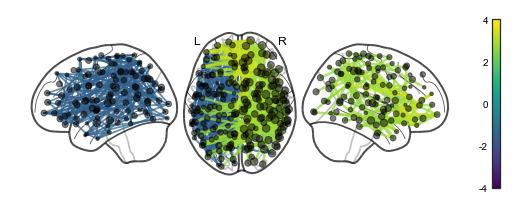

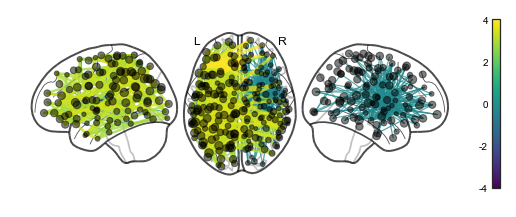

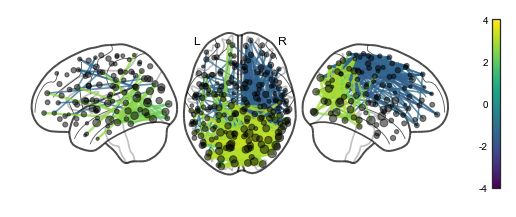

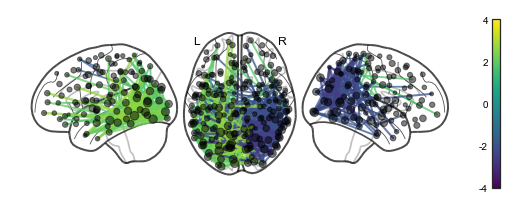

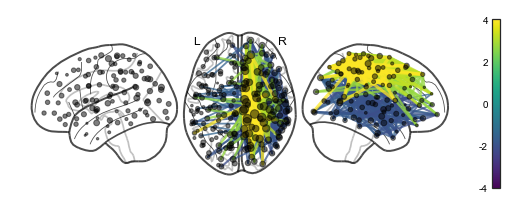

In [6]:
# plot top 5 components from MCA
var_explained = data['MCA'][0][0][4]
print('Mean variance explained for components (%)',
      np.mean(var_explained, axis=0) * 100)

components = data['MCA'][0][0][6]
for comp in range(0, 5):
    cm = components[:, :, comp]
    cm = cm + cm.T
    cm_degree = np.sum(abs(cm), axis=1)
    cm = do_threshold(cm, num_edge=500)
    cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
    plotting.plot_connectome(cm,
                             MNIcoordinates,
                             node_size=cm_degree_plot,
                             node_color='black',
                             edge_cmap='viridis',
                             edge_vmin=-4,
                             edge_vmax=4,
                             colorbar=True,
                             display_mode='lzr',
                             edge_kwargs={'Alpha': 0.75},
                             node_kwargs={'Alpha': 0.50})
    plotting.show()

## CCA Results
Only one mode is significant after correcting via permutations. It loads positively onto the APM and Spatial Neglect, and neglativly onto verbal fluency. The connectivity is pretty clearly determined by damage on the left associated with language and the right associated with spatial neglect/APM.

When investigating the associted networks a fairly clear patterns emerges whereby the APM/spatial neglect/ right hemisphere damage is associated with control and attention networks - makes sense! The left-hemisphere /verbal fluency damage is associated with more diffuse, potentially subcortical connection damage.

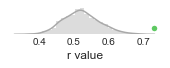

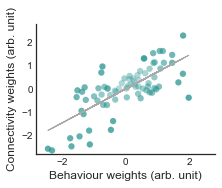

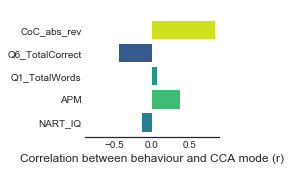

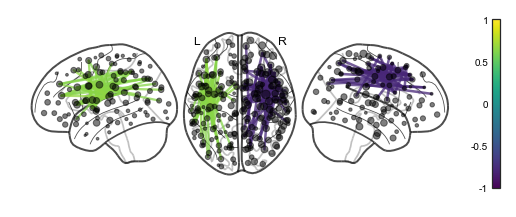

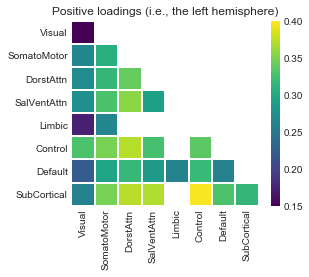

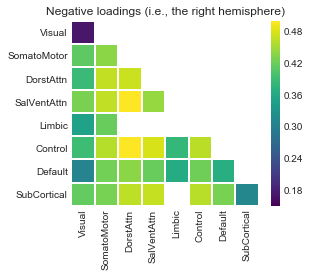

In [7]:
#plot CCA results for mode 1
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]
mode = 0
predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=100)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.4,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings (i.e., the left hemisphere)')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.5,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings (i.e., the right hemisphere)')
plt.show()

### Leave-one-out prediction of behavioural scores
The CCA can predict 3/5 behaviours (in line with the behavioural loadings above).

Remember that we wouldn't expect it to predict the NART (so, 3/4).

This is kind of impressive because it is distilling each individual into a single value + a simple transformation for each behaviour to acheive this level of accuracy. Suggests that a low dimensional description is quite useful for predicting a left out individual's cognitive scores (on some tasks).

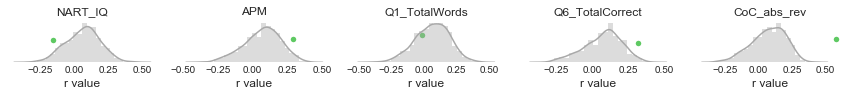

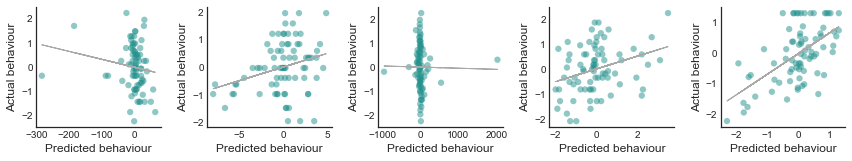

In [8]:
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

# Supplementary figures and analysis

Various supplemental analyses.

## Mode 2?
Arguably the permutation approach taken <cite data-cite="1496076/84MBLIL2"></cite> is a harsh on canonical variates beyond the first. Is Mode 2 interesting and or helpful to interpet?

Maybe yes! It predicts the language task that could not be predicted in mode 1 reasonably well. It is associated with damage to a left-hemisphere superior network. Need to think what this might mean in terms of localisation.

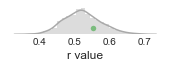

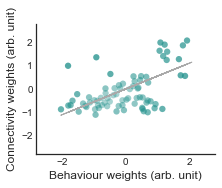

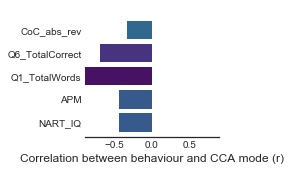

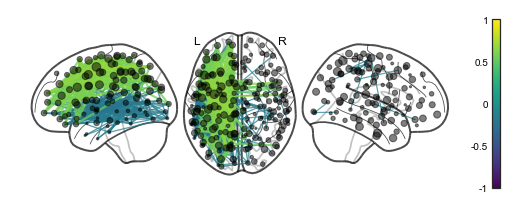

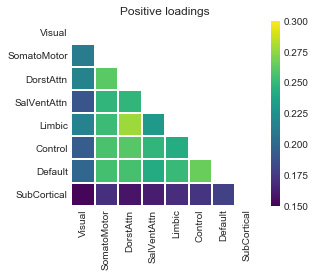

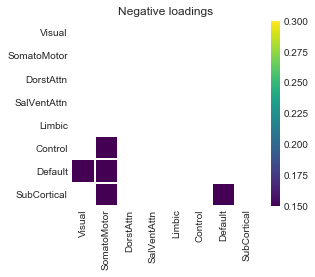

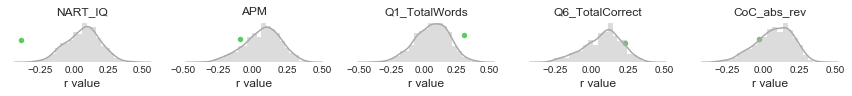

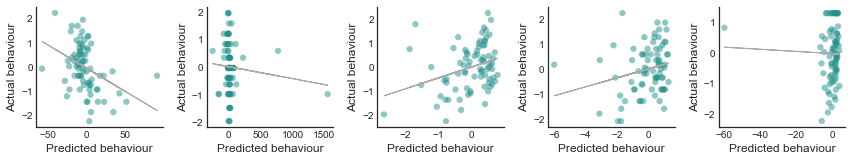

In [9]:
#plot CCA results for mode 2
mode = 1
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]

predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=500)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.3,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.3,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings')
plt.show()
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

## Behavioural data transform
After the transform no behavioural data violates normality assumptions

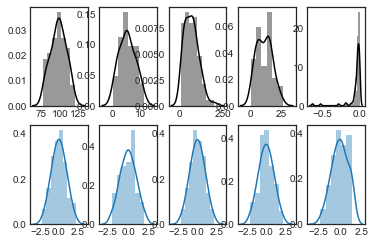

In [10]:
#plot behavioural transforms
beh = data['behav'][0][0][2]
beh_tf = data['behav'][0][0][4]
num_beh = np.shape(beh_tf)[1]
for measure in range(num_beh):
    plt.subplot(2, num_beh, measure + 1)
    sns.distplot(beh[:, measure], color='black')
    plt.subplot(2, num_beh, measure + 1 + num_beh)
    sns.distplot(beh_tf[:, measure])
plt.show()

## What happens if you perform the CCA on the voxels?
- 1) Left - right axis is the same.
- 2) Predictions are not as impressive. Presumably because it doesn't seem to capture as many subject's data (many 0-loadings)

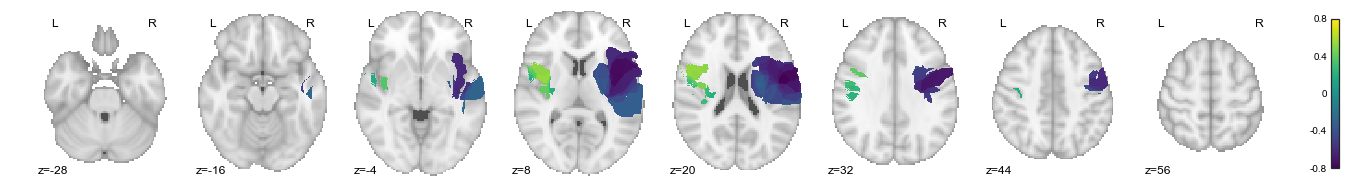

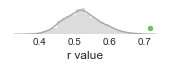

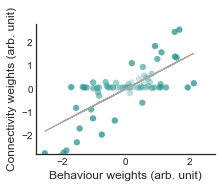

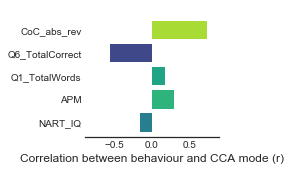

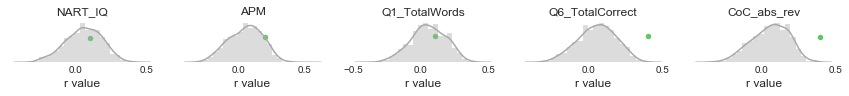

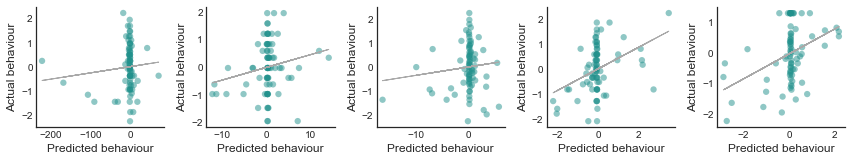

In [12]:
#voxelwise CCA results
mode = 0
img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/CCA_Mode' + str(
    mode + 1) + '.nii'
slices = np.arange(-28, 62, 12)
plotting.plot_stat_map(img,
                       threshold=0,
                       colorbar=True,
                       cmap='viridis',
                       display_mode='z',
                       cut_coords=(slices))
plt.show()

results_dir = docs_path + 'Results/voxelwise/'
data_v = scipy.io.loadmat(results_dir + 'results.mat')
U = data_v['CCA'][0][0][2]
V = data_v['CCA'][0][0][3]
r = data_v['CCA'][0][0][4]
r_perms_v = data['CCA'][0][0][9]
behaviour_loading = data_v['CCA'][0][0][13]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

real_values = data_v['CCA'][0][0][6]
predicted_values = data_v['CCA'][0][0][5]
predicted_values = predicted_values[:, :, mode]
r_values = data_v['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data_v['CCA'][0][0][10]
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

### Empirical comparison to connectivity based CCA

## Single example lesion subject
Note the widespread effects of a lesion

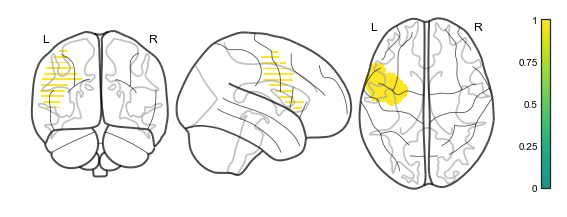

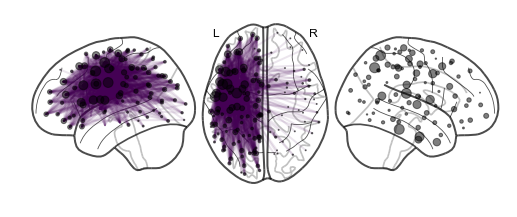

In [13]:
#single sub example
img = '/Users/luke/Documents/Projects/StrokeNet/Data/lesionMaps/3_rNii/rP002_SP.nii'
plotting.plot_glass_brain(img, threshold=0, colorbar=True, cmap='viridis')
cm = data['Cdiff']
cm = cm[:, :, 1] > 0
cm = cm + cm.T
cm_degree = np.sum(abs(cm), axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 100
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=1,
                         edge_vmax=2,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.10},
                         node_kwargs={'Alpha': 0.50})
plt.show()

## Replication in another parcellation
Results look very similar.

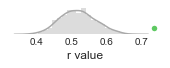

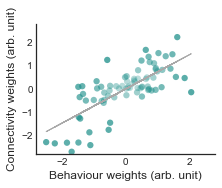

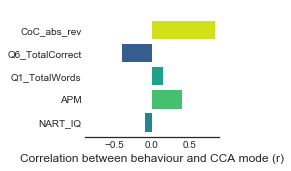

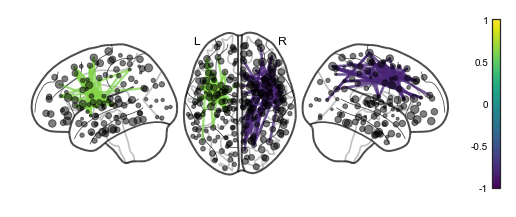

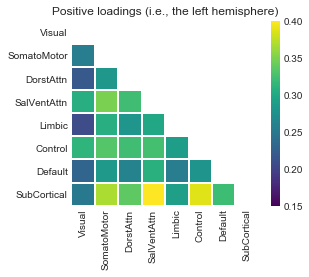

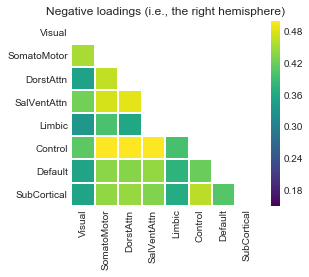

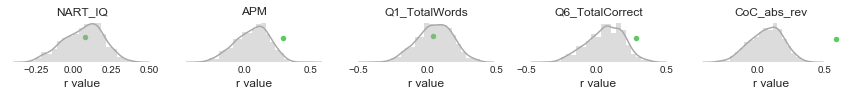

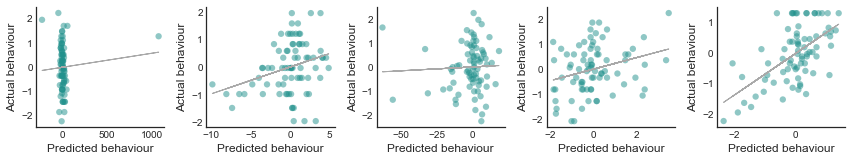

In [14]:
# Brainnetome atlas results
docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
parc = 'BN'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')

#network info
MNIcoordinates = data['COG']
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]
mode = 0
predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[mode, :]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=100)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.4,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings (i.e., the left hemisphere)')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.5,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings (i.e., the right hemisphere)')
plt.show()

mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

# Methods

(This is just a minimal effort draft, to note what we did)

## Participants
200+ number of participants were examined at __ hospital. __ were excluded due to __ . A further __ were excluded due to __ . The final sample included 78 participants. This study was approved by __ .
 
Table:
Age – mean +- std (range)
Gender
Chronicity
Var 1
Var 2
Var 3

 
## Behavioural data
Participants completed an extensive neuropsychological battery. Here we present detailed analyses on five behavioural measures; the National Adult Reading Test (NART), the Raven's Advanced Progressive Matrices (RPM), the Bell's cancellation task (BELL) and two language measures (verbal fluency and ___ ). These measures represent a mixture of higher cognitive abilities (e.g., fluid and crystallized intelligence), basic attentional capacity and language measures that are commonly assessed after an individual suffers from a stroke. Behavioural variables were transformed using __.
 
## Lesion Mapping
Individual patient lesion maps were drawn onto the Colin27 structural template (every sixth axial slice) by author Z.N. and, in specific cases, were verified by an experienced radiographer. For the purposes of the network lesion mapping approach the lesions were transformed into MNI152 space.
 
## Lesion network mapping
Age and gender matched structural connectomes were generated using matlab scripts in conjunction with LEAD-DBS package (ref). Fiber tracts were drawn from the NKI-rockland dataset (ref) which were preprocessed as part of the normative connectomes project <cite data-cite="1496076/VFYXW2ML"></cite>
 
In brief, (preprocessing details will go here).
 
For each individual in the stroke cohort, the 20 closest connectomes in age were combined to create an individual-specific 'pre-lesion' normative streamline map. Then, any fiber tracts that intersected with the original three dimensional lesion map were deleted, creating a “post-lesion” streamline map. This approach is similiar to previous lesion-network mapping approaches (Tractotron ref) but with increased flexibility for subject selection and post-processing. 

Pre- and post-lesion tractograms were converted into connectomes using the Schaefer 200 atlas (ref) with an additional 14 subcortical regions (HO-atlas, ref) resulting in a 214 (node) by 214 (node) structural matrix for each individual. All analyses were repeated in an additional template (Brainnetome atlas, 246 regions) to confirm the robustness of the results.
 
## Patterns of lesion loading across participants
 
Connectivity lesion matrices were generated by subtracting the post-lesion matrix from the pre-lesion matrix and binarizing the resulting graph. The upper triangles of these matrices were concatenated into single participant by edge matrix. Any edge that did not demonstrate damage in at least 2 individuals was excluded.
 
In line with previous work using similiar methods (ref), brain features were subjected to dimensionality reduction prior to brain-behaviour mapping. We utilized multiple correspondence analysis (MCA). MCA is a counterpoint to principal components analysis but in the context of binary data. In keeping with previous work (Smith et al., 2016, AP, 2017, Xia 2018), we extracted the top ten MCA components for further analysis. For completeness we also tested across a range of component inclusions (5-20) which did not significantly affect the results.
 
## Multivariate analysis of brain behaviour relationships

### CCA
To calculate associations between behaviour and modelled connectivity loss we used canonical correlation analysis (CCA). CCA has previously been used to uncover latent many-to-many relationships within brain and behavioural data (Smith et al., Wang, Xia, Mihalik, 2019)
...

*Will add formula for CCA here.*


CCA aims to find associated sources of variability that describe the correspondence between two sets of variables (Wang, 2018). Finds interpretable projections of high-demsional datasets onto low-dimensional linear representations, i.e. canonical variates. Based on maximizing the linear corresponance in the low-dimensional space. 

The X behavioural variables were entered as behavioural variables. The top five variance explaining MCA components were also inputed. Brain and behavioural variables were mean centered and transformed to a normal distribution (say what transformation)
 
The CCA output five ‘modes’, of which the first two were statistically significant (p < 0.001 and p ~ 0.02). Each mode corresponds to the maximum residual co‐variation between the two sets of variables (behaviour and connectivity-based components).
 
I’ve visualized the top/bottom 100 edges expressed by each mode, for now (fully weighted results can be presented in Supplementary). 

### Leave-one-out procedure

To test the accuracy of behavioural predictions garnered by the CCA a leave-one-out prediction procedure was used. Additional benefit is that CCA is fairly sensitive to outliers, this is an additional protection against that.

A single subject's data behavioural scores and connectivity pattern was left-out.

MCA and CCA was conducted on remaining participants.

We are interested in predict from lesion to behaviour, so the left-in MCA was applied to the left out single subject (using r function __ from __ ). Then the connectivity components were multipled by the connectivity-based canonical coefficents (*B*) resulting in the left out subject connectivity-based canonical variable (*V*). A linear regression was performed on the trained canonical variables (*U* and *V*). This was then applied to the held out connectivity-based canonical variable (*V*) to estimate the held-out behaviour-based canonical variable (*U*). Finally, this was divided by the behaviour-based canoical coefficients (*A*) to create a predicted set of behaviours for the held out subject.

This procedure was performed for each subject in the sample resulting in an N by behaviours (78 x 5) set of predictions. Each actual and predicted score was correlated, resulting in a single r-value for each canonical variate and behaviour.


### Permutation testing of significance
Holding one set of data constant (the connectivity), while shuffling the behavior, breaking the link between brain and behavioural features.

This was applied to the CCA r values as well as the accuracy of the behavioural predictions.

### Visualising results

Just need to note that because we did a LOO analysis the presented results are averaged across the iterations.

Also, we present the highest weighted edges for interpretation (see supp. X for full results).

### Confirmatory analyses
•	Independent parcellations (see Supplementary X)
•	Repeated analyses sans normative connectomes, using voxels.
•	Size of normative connectome: procedure was repeated for the 15 and 20 closest connectomes in age to confirm the robustness of the results (see Supplementary X)
•	Analyses were repeated including control variables including age and chronicity (see Supplementary X). These variables did not result in significant weights and could not be predicted by connectivity damage.

Matlab code to achieve the lesion network mapping in conjunction with LEAD DBS() and the statistical analysis are available at X.


# References
<div class="cite2c-biblio"></div>

In [18]:
# export this notebook
import os
os.system('jupyter nbconvert --to html_toc --CodeFoldingPreprocessor.remove_folded_code=True StrokeNetProject.ipynb')

0